# ClimateNet AR Analysis: Western US

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
# Previously: needed cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
# This was resolved in nc-time-axis 1.3.0 (https://github.com/SciTools/nc-time-axis/releases/tag/v1.3.0)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:42384,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Analysis notes
- replace `.where` with `.clip` if possible for speed
- CESM "IVT" output along with AR conditions
- circulation anomalies as in fronts analysis (wait for RCP8.5 masks)

## Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/p/cgd/ccr/people/tking/cgnet_masks/" # retrained NCAR model, 2000-2015

In [5]:
cesm_cnet_folder = "tmq_psl_v850_u850/" # 4 variables
#cesm_cnet_folder = "tmq_v850/" # 2 variables
#cesm_cnet_folder = "tmq_only/" # 1 variable

### CESM historical simulations

In [6]:
#cnet_files = "class_masks*.nc" # retrained NCAR model
#cnet_files = "class_masks.2000.test.nc" # testing year 2000
cnet_files = "class_masks.200[0-5]*" # testing years 2000-2005 (historical simulation)

### Set regional bounds

In [7]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,250)

### Preprocessing function to subset regionally

In [8]:
def preprocess_region(ds):
    # rename data variable
    dsr = ds.rename({'__xarray_dataarray_variable__': 'output_tag'})
    # return regional domain
    return dsr['output_tag'].sel(lat=lat_bounds,lon=lon_bounds)

## Read in masks with preprocessing

In [9]:
%%time
cnet = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folder+cnet_files, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 444 ms, sys: 41.9 ms, total: 486 ms
Wall time: 4.88 s


In [10]:
cnet

<xarray.DataArray 'output_tag' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 1.9.9 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    ...                         ...
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             casper19
    remap_version:              4.7.9
    map_file:                   /glade/work/nanr/mapfiles/map_ne120_to_0.23x0...
    input_file:                 ./b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PSL.20...
    CDO:                        Climate Data Operators version 1.9.9 (https:/...

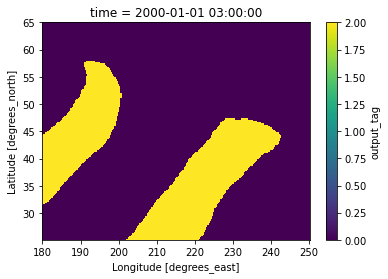

In [25]:
cnet.isel(time=0).plot();

### Regional heatmap

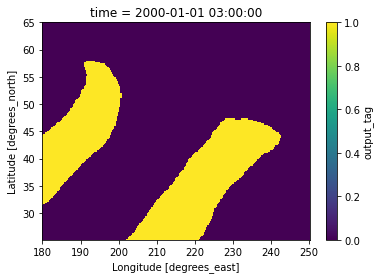

In [63]:
# set ARs = 1 and everything else 0
(cnet.clip(min=1)-1).isel(time=0).plot();

In [11]:
AR = cnet.clip(min=1)-1
AR

<xarray.DataArray 'output_tag' (time: 17520, lat: 170, lon: 225)>
dask.array<sub, shape=(17520, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00

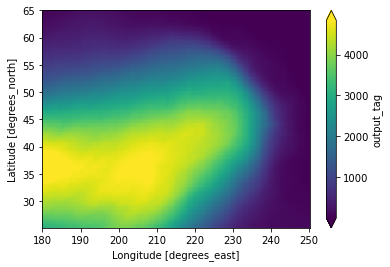

In [65]:
AR.sum(dim='time').plot(robust=True);

In [12]:
npercentARs = 100*(AR.sum(dim='time'))/len(cnet.time)

In [13]:
npercentARs = npercentARs.persist()

In [30]:
npercentARs.max().values

array(29.09817352)

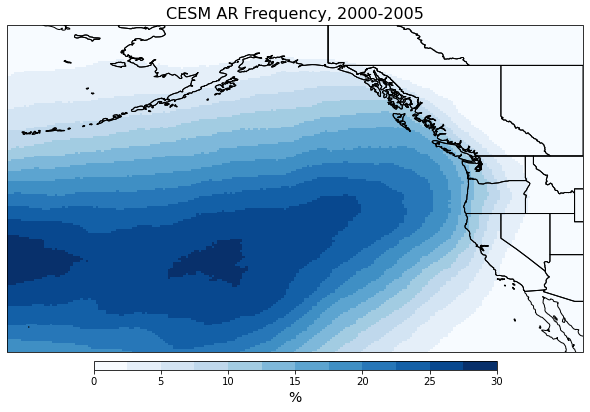

In [42]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=30, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.BORDERS, zorder=2) # duplicative?
ax.add_feature(cfeature.STATES, zorder=3)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2000-2005', fontsize=16); 
#ax.set_title('CESM AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_CESM_hist.png', bbox_inches='tight')

### Seasonal heatmaps

In [14]:
# getting the number of time points in each season (they vary due to month lengths)
season_lengths = cnet.time.groupby('time.season').count()
season_lengths

<xarray.DataArray 'time' (season: 4)>
array([4320, 4416, 4416, 4368])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

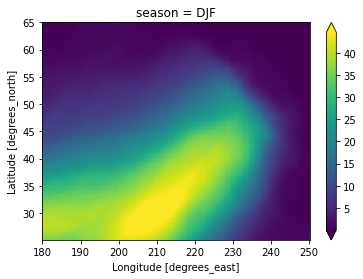

In [15]:
npercentARs_byseason = 100*((cnet.clip(min=1)-1).groupby('time.season').sum(dim='time'))/season_lengths
npercentARs_byseason.sel(season='DJF').plot(robust=True);

In [16]:
npercentARs_byseason = npercentARs_byseason.persist()

In [49]:
npercentARs_byseason.max().values

array(47.63888889)

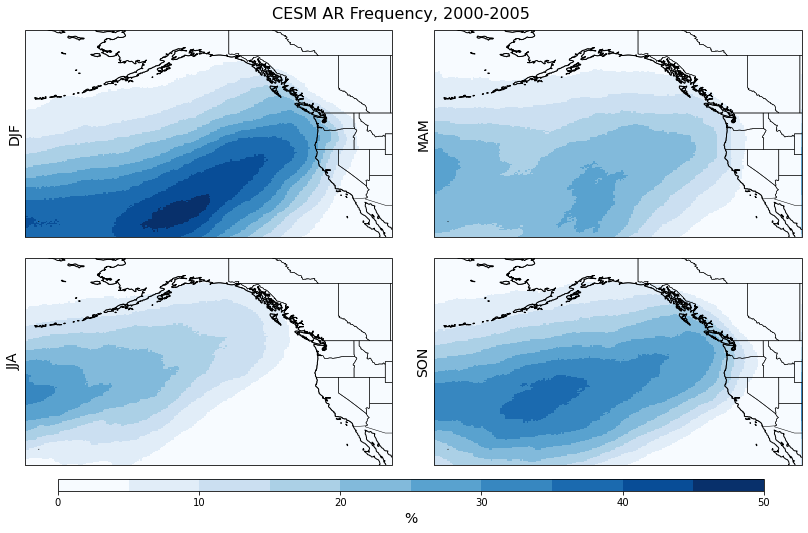

In [51]:
# a nicer plot
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 10) # ARTMIP region

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason.sel(season=season), coord=npercentARs_byseason.lon)
    lat = npercentARs_byseason.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=50, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency, 2000-2005', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentARs_WUS_CESM_hist_byseason.png', bbox_inches='tight')

## Read in landfrac for this grid
To subset land points

In [17]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)
landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)
#landfrac

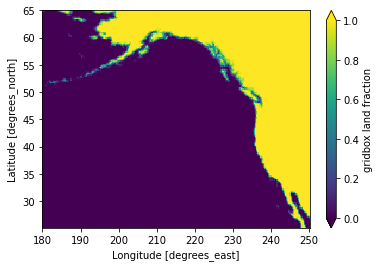

In [53]:
landfrac.plot(robust=True);

## Read in precipitation field

In [18]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output

In [19]:
# h4.PRECT is 3hrly instantaneous
# h3.PRECT is 3hrly average

#PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
#PRECT_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT.2000010100Z-2000123121Z.FV.nc" # testing year 2000 only
PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h3.PRECT*regrid*"

### Preprocessing function to return PRECT only
with option to subset spatially (save memory)

In [20]:
def preprocess_PRECT(ds):
    #return ds['PRECT']
    return ds['PRECT'].sel(lat=lat_bounds,lon=lon_bounds)

### Read in PRECT files

In [21]:
%%time
PRECT_hist = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_PRECT)
#PRECT_hist = xr.open_dataset(cesm_hist_filepath+PRECT_hist_file, chunks={'time':500,'lat':100,'lon':200})

CPU times: user 1.19 s, sys: 72 ms, total: 1.26 s
Wall time: 10.4 s


In [61]:
PRECT_hist

<xarray.DataArray 'PRECT' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=float32, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

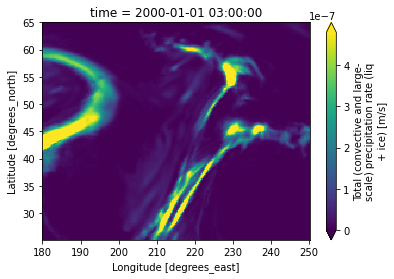

In [62]:
PRECT_hist.isel(time=0).plot(robust=True);

## Calculate fraction of total precipitation associated with an AR

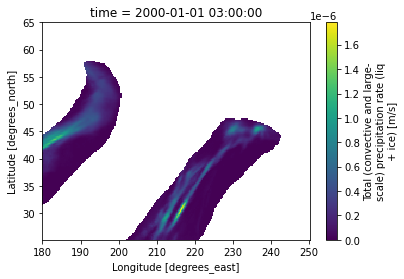

In [86]:
PRECT_hist.where(AR==1).isel(time=0).plot()

In [22]:
def calc_prect_AR(PRECT, AR):

    # precipitation overlapping with AR
    PRECT_AR = PRECT.where(AR==1).sum(dim='time')
    
    # total precipitation
    PRECT_sum = PRECT.sum(dim='time')
    
    # proportion of precip overlapping with AR
    PRECT_AR_frac = 100*(PRECT_AR/PRECT_sum)
    
    # seasonal breakdown
    PRECT_AR_byseason = PRECT.where(AR==1).groupby("time.season").sum(dim='time')
    PRECT_sum_byseason = PRECT.groupby("time.season").sum(dim='time')
    PRECT_AR_frac_byseason = 100*(PRECT_AR_byseason/PRECT_sum_byseason)
    
    # return annual total and by season
    return(PRECT_AR_frac, PRECT_AR_frac_byseason)

In [23]:
# return seasonal values for plots
PRECT_AR_frac, PRECT_AR_frac_byseason = calc_prect_AR(PRECT_hist, AR)

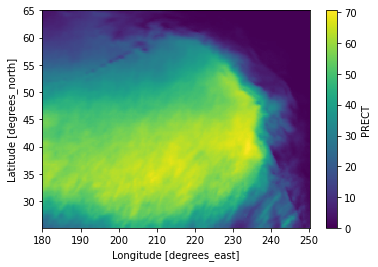

In [84]:
PRECT_AR_frac.plot();

In [24]:
PRECT_AR_frac_byseason = PRECT_AR_frac_byseason.persist()
print(PRECT_AR_frac_byseason.max().values)

81.8158


### Seasonal spatial plots

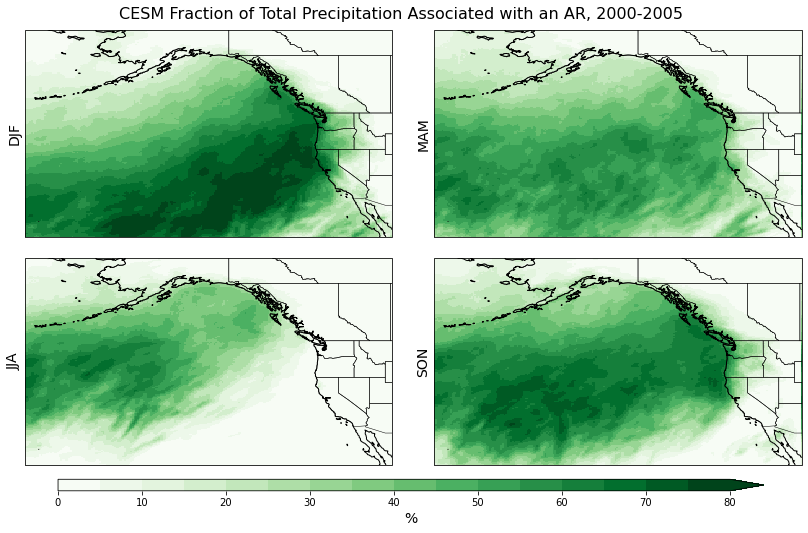

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PRECT_AR_frac_byseason.sel(season=season), coord=PRECT_AR_frac_byseason.lon)
    lat = PRECT_AR_frac_byseason.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM Fraction of Total Precipitation Associated with an AR, 2000-2005', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PRECT_AR_WUS_CESM_hist_byseason.png', bbox_inches='tight')

## Process extreme precipitation for a given data array and percentile

In [25]:
def process_PEx(PRECT, landfrac, percentile):
         
    # subset for land only (optional; comment out to use whole domain)
    PRECT = PRECT.where(landfrac > 0)
    
    quantile = percentile/100
    
    # PEx over time
    pX = PRECT.chunk({'time': -1}).quantile(quantile, dim='time')
    PEx = PRECT.where(PRECT > pX)
    
    # PEx by season
    pX_season = PRECT.chunk({'time': -1}).groupby("time.season").quantile(quantile, dim='time')
    PEx_season = PRECT.groupby("time.season").where(PRECT.groupby("time.season") > pX_season)
    
    return(PEx, PEx_season)

In [26]:
%%time
percentile=90
PEx, PEx_season = process_PEx(PRECT_hist, landfrac, percentile)

CPU times: user 332 ms, sys: 1.7 ms, total: 334 ms
Wall time: 343 ms


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

In [98]:
PEx

<xarray.DataArray 'PRECT' (time: 17520, lat: 170, lon: 225)>
dask.array<where, shape=(17520, 170, 225), dtype=float32, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon       (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * time      (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

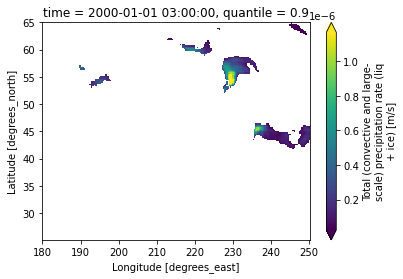

In [99]:
# note this is land only
PEx.isel(time=0).plot(robust=True);

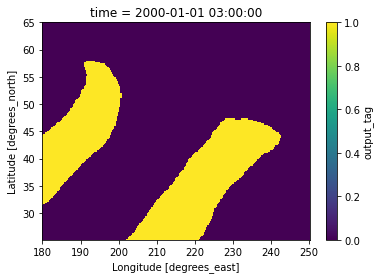

In [100]:
# ARs at the same time index
AR.isel(time=0).plot();

## Calculate fraction of extreme precipitation associated with an AR
### Also return total extreme precipitation
Note for processing global files: Memory can be an issue unless subsetting a specific region.\
Possible solutions could include launching jupyter on compute node for >4GB memory and/or modify client memory and workflow to reduce data sizes.

In [27]:
def calc_overlap(AR,PEx,PEx_season):
    
    # Compute sum of extreme precipitation amount over time at each gridpoint
    PEx_sum = PEx.sum(dim='time')
    # subset for land only (optional; comment out to use whole domain)
    PEx_sum = PEx_sum.where(landfrac > 0)

    # By season
    PEx_sum_byseason = PEx_season.groupby("time.season").sum(dim='time')
    PEx_sum_byseason = PEx_sum_byseason.where(landfrac > 0)
      
    # PEx overlapping with AR, sum over time
    PEx_AR = PEx.where(AR==1).sum(dim='time')
    PEx_AR_byseason = PEx_season.where(AR==1).groupby("time.season").sum(dim='time')
    
    PEx_AR_frac = 100*(PEx_AR/PEx_sum)
    PEx_AR_frac_byseason = 100*(PEx_AR_byseason/PEx_sum_byseason)
    
    return(PEx_AR_frac, PEx_AR_frac_byseason, PEx_sum, PEx_sum_byseason)

In [28]:
PEx_AR_frac, PEx_AR_frac_byseason, PEx_sum, PEx_sum_byseason = calc_overlap(AR, PEx, PEx_season)

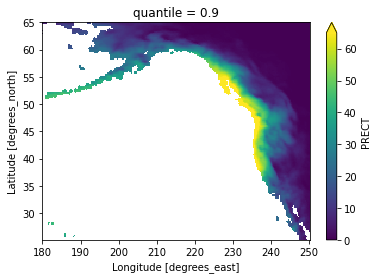

In [106]:
PEx_AR_frac.plot(robust=True);

In [29]:
PEx_AR_frac_byseason = PEx_AR_frac_byseason.persist()
print(PEx_AR_frac_byseason.max().values)

87.30429


### Seasonal spatial plots

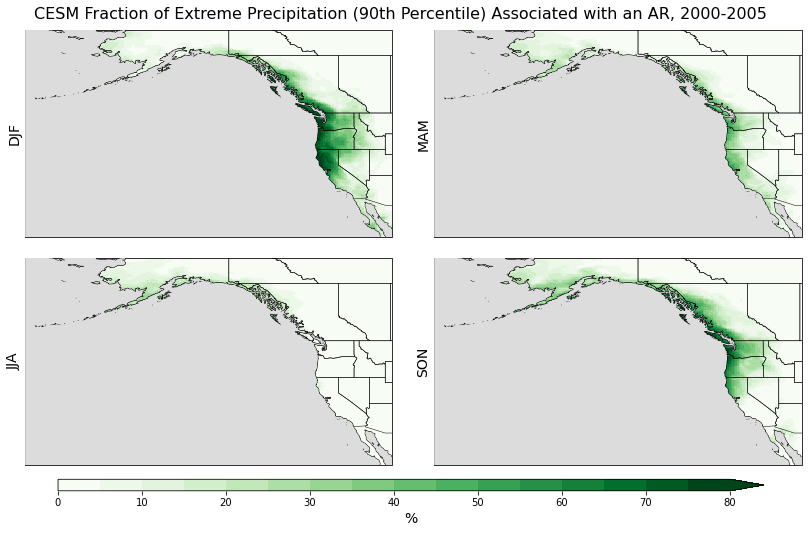

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 16)
vmax = 80

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PEx_AR_frac_byseason.sel(season=season), coord=PEx_AR_frac_byseason.lon)
    lat = PEx_AR_frac_byseason.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar for absolute plots
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM Fraction of Extreme Precipitation (90th Percentile) Associated with an AR, 2000-2005', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# reminder to set dpi=300 for publications
#plt.savefig('../figures/toSCP/PEx90_AR_WUS_CESM_hist_byseason.png', bbox_inches='tight')

## Process plots for AR precipitation
### Custom precip colormap from unidata
https://unidata.github.io/python-gallery/examples/Precipitation_Map.html

In [30]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap_prec = mcolors.ListedColormap(cmap_data, 'precipitation')
norm_prec = mcolors.BoundaryNorm(clevs, cmap_prec.N)

In [112]:
# testing time indexing
t = '2000-08-21T21'
PRECT_hist.sel(time=t)[0]

<xarray.DataArray 'PRECT' (lat: 170, lon: 225)>
dask.array<getitem, shape=(170, 225), dtype=float32, chunksize=(170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
    time     object 2000-08-21 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_methods:   time: mean
    cell_measures:  area: area

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

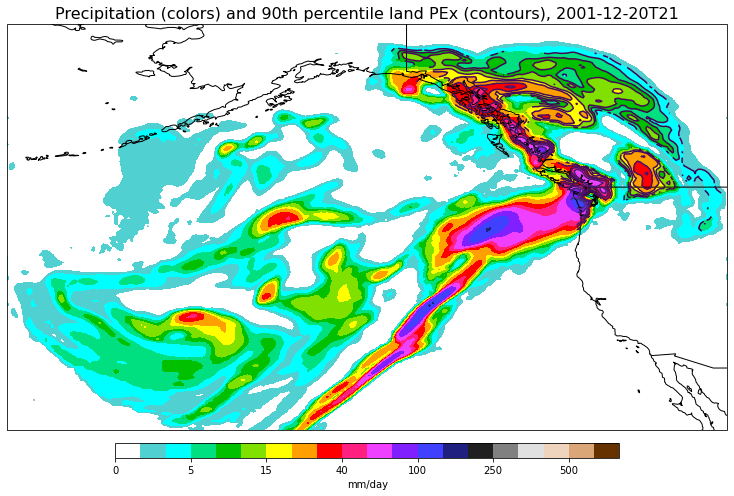

In [113]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

# PEx contours first (land only)
pfield = PEx.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_PEx = ax.contour(lon, lat, field, clevs, transform=ccrs.PlateCarree())

# PRECT filled contour second (land & ocean)
pfield = PRECT_hist.sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())
#c_prec = ax.pcolormesh(lon, lat, field, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Precipitation (colors) and 90th percentile land PEx (contours), '+t, fontsize=16);
#ax.set_title('90th percentile precipitation, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_PEx90_CESM_2001-12-20-21.png', bbox_inches='tight')

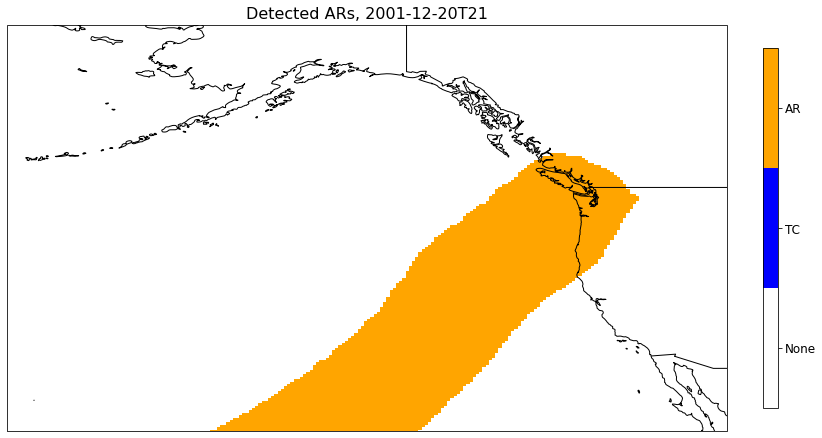

In [141]:
# ARs at the same time index
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0)) # the central_longitude is important when region extends to/beyond longitude 180

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

ffield = cnet.sel(time=t)[0]
field, lon = add_cyclic_point(ffield, coord=ffield.lon)
lat = ffield.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# colorbar
cbar_ax = fig.add_axes([1.05, 0.25, 0.02, 0.5])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# add title
ax.set_title('Detected ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/ARs_CESM_2001-12-20-21.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

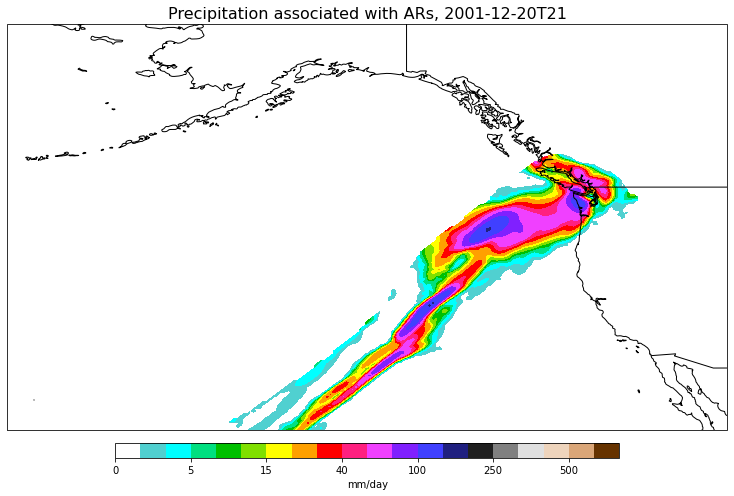

In [142]:
# PRECT_AR at the same time index
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# select time index
t = '2001-12-20T21'

pfield = PRECT_hist.where(AR==1).sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Precipitation associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PRECT_AR_CESM_2001-12-20-21.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

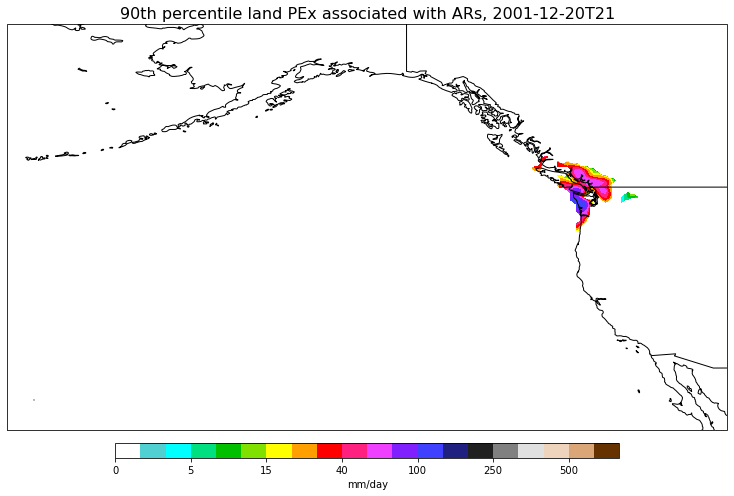

In [143]:
# PEx_AR at the same time index - note land only PEx points
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

# select time index
t = '2001-12-20T21'

pfield = PEx.where(AR==1).sel(time=t)[0]*1000*86400
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# extending the spatial range to force the map to plot more (where there is no PEx_AR)
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# precip colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.18, 0.7, 0.02])
cbar_prec = plt.colorbar(c_prec, cax=cbar_prec_ax, orientation='horizontal')
cbar_prec.set_label('mm/day')

# add title
ax.set_title('90th percentile land PEx associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx90_AR_CESM_2001-12-20-21.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

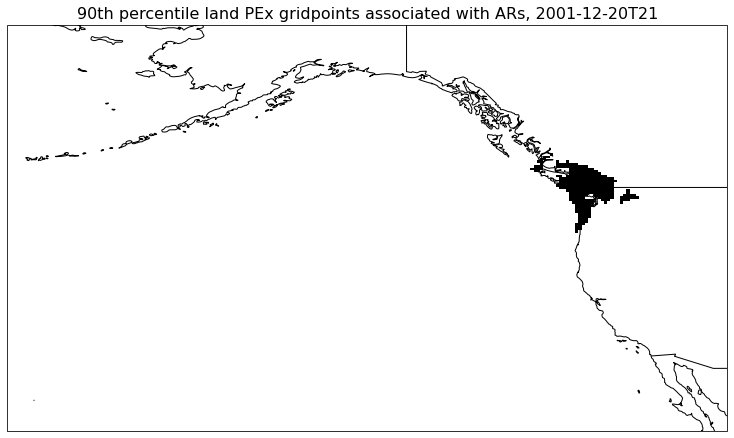

In [144]:
# gridpoints only (no precip info)

fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
t = '2001-12-20T21'

pfield = (PEx.where(AR==1).sel(time=t)[0]*1000*86400).notnull()
field, lon = add_cyclic_point(pfield, coord=pfield.lon)
lat = pfield.lat
c_prec = ax.pcolormesh(lon, lat, field, cmap='Greys', transform=ccrs.PlateCarree())

ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add title
ax.set_title('90th percentile land PEx gridpoints associated with ARs, '+t, fontsize=16);

#plt.savefig('../figures/toSCP/PEx90_AR_binary_CESM_2001-12-20-21.png', bbox_inches='tight')

## Visualizing AR Precip Fractions

In [31]:
def calc_prect_AR_time(PRECT, AR):

    # precipitation overlapping with AR
    PRECT_AR = PRECT.where(AR==1).sum(dim=('lat','lon'))
    
    # total precipitation
    PRECT_sum = PRECT.sum(dim=('lat','lon'))
    
    # proportion of precip overlapping with AR
    PRECT_AR_frac = 100*(PRECT_AR/PRECT_sum)
    
    # return annual total and by season
    return(PRECT_AR_frac)

In [32]:
PRECT_AR_frac_time = calc_prect_AR_time(PRECT_hist, AR)

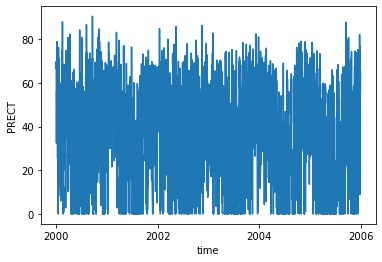

In [33]:
PRECT_AR_frac_time.plot();

In [34]:
# mean by month of year
PRECT_AR_frac_time_monthofyear = PRECT_AR_frac_time.groupby("time.month").mean().persist()
# standard deviation
PRECT_AR_frac_time_monthofyear_std = PRECT_AR_frac_time.groupby("time.month").std().persist()

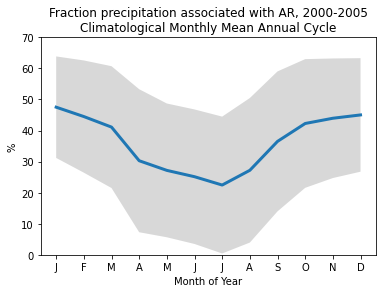

In [36]:
# with fill for standard deviation
plt.plot(PRECT_AR_frac_time_monthofyear.month, PRECT_AR_frac_time_monthofyear, linewidth=3)
plt.fill_between(PRECT_AR_frac_time_monthofyear.month, PRECT_AR_frac_time_monthofyear-PRECT_AR_frac_time_monthofyear_std, 
                PRECT_AR_frac_time_monthofyear+PRECT_AR_frac_time_monthofyear_std, alpha=0.3, facecolor='grey')
plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month of Year')
plt.ylabel('%')
plt.ylim([0,70])
#plt.title('Percent PEx gridpoints associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');
plt.title('Fraction precipitation associated with AR, 2000-2005\nClimatological Monthly Mean Annual Cycle');

#plt.savefig('../figures/toSCP/PRECT_AR_monthofyear_withstdev_WUS_CESM_hist.png', bbox_inches='tight')

In [37]:
# mean by time of day
PRECT_AR_frac_time_timeofday = PRECT_AR_frac_time.groupby("time.hour").mean().persist()
# standard deviation
PRECT_AR_frac_time_timeofday_std = PRECT_AR_frac_time.groupby("time.hour").std().persist()

In [38]:
# 3hrly frequency
PRECT_AR_frac_time_timeofday.hour

<xarray.DataArray 'hour' (hour: 8)>
array([ 0,  3,  6,  9, 12, 15, 18, 21])
Coordinates:
  * hour     (hour) int64 0 3 6 9 12 15 18 21

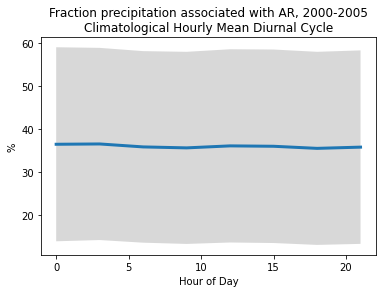

In [39]:
plt.plot(PRECT_AR_frac_time_timeofday.hour, PRECT_AR_frac_time_timeofday, linewidth=3)
plt.fill_between(PRECT_AR_frac_time_timeofday.hour, PRECT_AR_frac_time_timeofday-PRECT_AR_frac_time_timeofday_std, 
                PRECT_AR_frac_time_timeofday+PRECT_AR_frac_time_timeofday_std, alpha=0.3, facecolor='grey')
plt.xlabel('Hour of Day')
plt.ylabel('%')
#plt.ylim([0,30]) # withstdev
plt.title('Fraction precipitation associated with AR, 2000-2005\nClimatological Hourly Mean Diurnal Cycle');

## Probability Ratios

$PR = (N_P|F/N_F)/(N_P/N)$ where $N$, $N_P$, $N_F$, and $N_P|F$ are the number of time steps, number of time steps with extreme precipitation, number of time steps with fronts, and number of extreme precipitation time steps associated with fronts, i.e., comparing the conditional probability of extreme precipitation during fronts to the climatological probability of extreme precipitation

#### Seasonal PRs

In [59]:
def prob_ratio_season(AR, PEx):
    # number of time steps in each season
    N_season = AR.time.groupby('time.season').count()
    
    # number of time steps in each season with extreme precipitation (spatial maps; constant over space)
    N_P_season = PEx.notnull().groupby('time.season').sum(dim='time')
    
    # number of time steps in each season with ARs (spatial maps)
    N_AR_season = AR.where(AR==1).groupby('time.season').sum(dim='time')
    
    # number of extreme precipitation time steps in each season associated with ARs (spatial maps)
    N_P_AR_season = PEx.where(AR==1).notnull().groupby('time.season').sum(dim='time') 
       
    # probability ratio
    PR_season = (N_P_AR_season/N_AR_season)/(N_P_season/N_season)
    
    return(PR_season)

In [61]:
PR_season = prob_ratio_season(AR, PEx_season)

In [62]:
PR_season = PR_season.persist()
print(PR_season.max().values)
print(PR_season.min().values)

10.0
0.0


PR is larger than one when the conditional occurrence exceeds the unconditional occurrence probability.\
PR is close to one when extreme precipitation is not associated with AR occurrence.\
See Fischer & Knutti (2015)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/g

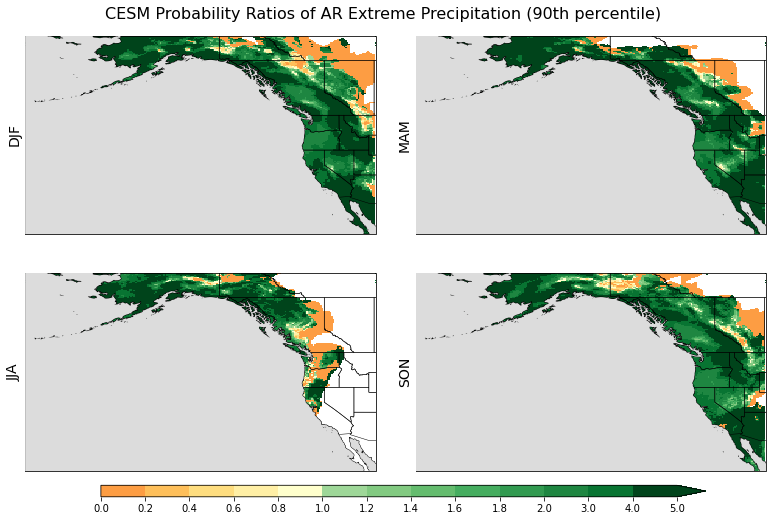

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# using color sampled from Greens and Yellows
greens = plt.cm.get_cmap('Greens', 14)
greens_cmap = greens(range(14))
yellows = plt.cm.get_cmap('YlOrRd', 10)
yellows_cmap = yellows(range(5))
greens_cmap[:5] = np.flip(yellows_cmap, axis=0) # replace first 5 colors with flipped yellows
cmap = mpl.colors.ListedColormap(greens_cmap)
bounds = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,3,4,5] # custom bounds sampling close to 1 on either side
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

vmin=0
vmax=5

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(PR_season.sel(season=season), coord=PR_season.lon)
    lat = PR_season.lat
    pc = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    # add greyed out ocean
    axs[i].add_feature(cfeature.OCEAN, zorder=3, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb1_ax = fig.add_axes([0.22, 0.08, 0.6, 0.02])
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max', ticks=bounds)

# add title
fig.suptitle('CESM Probability Ratios of AR Extreme Precipitation (90th percentile)', fontsize=16, y=0.93)

plt.subplots_adjust(wspace=0, hspace=0.2)

#plt.savefig('../figures/toSCP/PR90_AR_WUS_CESM_hist_byseason.png', bbox_inches='tight')